In [219]:
# 1. panel 1 - table - average depth of sequencing - make table and make barplot with st dev&dots. 
# 8. all donors vs all donors (all marks) peaks correlation / inclusion metrics.

In [220]:
import os, sys
import re
from collections import OrderedDict
from itertools import chain

from pathlib import Path
import pandas as pd

In [270]:
output = !dirname $(pwd)
# detect:
PROJECT_ROOT_PATH = output[0]
# or custom path:
# PROJECT_ROOT_PATH = "~/work/washu"
sys.path.insert(0, os.path.expanduser(PROJECT_ROOT_PATH))

# whether to clear cached_results or not:
clear_cache = False

In [222]:
import reports.bed_metrics as bm
import reports.loci_of_interest as loi

In [223]:
import matplotlib.pyplot as plt

In [224]:
def color_annotator_hist(label):
    chunks = list(label.split("_"))
    hist, _donor, _tool = chunks
    color = {'H3K4me1':'lightblue', 'H3K4me3':'red', 'H3K27ac':'black',
             'H3K27me3':'green', 'H3K36me3':'lightgray'}[hist]

    return (("Histone", color),)

In [304]:
def build_fig8(hist_mods, df_path, jaccard,
               tools_label, df_failed_tracks, *,
               row_cluster=False,
               plot_path = None):
    print("Tools:")
    print(*["  {}:{}".format(k, v) for k,v in hist_mods.items()], sep="\n")

    # -----------------------------------
    # Collect tracks:
    hist_2_tracks = {}
    
    for f in hfolders:
        match = re.match(".*/(H[^/]*)/([^/]*).*", f, flags=re.IGNORECASE)
        assert match
        hist = match.group(1)
        tool = match.group(2)

        if hist_mods[hist] != tool:
            continue

        tracks = loi._collect_peaks_in_folder(Path(f))
        hist_2_tracks[hist] = tracks

    print("\nAll Tracks:")
    for h in hist_mods:
        tracks = hist_2_tracks[h]
        assert tracks, "No tracks for {}".format(h)
        print("  {} [{}], {}..{}".format(
            h, len(tracks), Path(tracks[0]).name, Path(tracks[-1]).name)
        )
    
    all_donors_paths = list(chain(*(hist_2_tracks[h] for h in hist_mods)))
    print("\nAll donors paths: (first 5) or {}".format(len(all_donors_paths)),
          *all_donors_paths[0:5], sep="\n    ")

    # -----------------------------------
    print("\nMetrics table:")
    print(df_path)
    df = bm.load_or_build_metrics_table(all_donors_paths, all_donors_paths, df_path,
                                        jaccard=jaccard,
                                        threads=30)
    
    # ------------------------------------
    def passed_mask(labels, df_failed_tracks):
        if labels is None:
            return [True for l in labels]
        
        passed_donors_for_hist = {}
        mask = []
        for label in labels:
            match = re.match(".*_(H[A-Z0-9]*)[_-].*", label, flags=re.IGNORECASE)
            assert match, "Unsupported donor label format: " + label
            hist = match.group(1)
            if hist not in passed_donors_for_hist:
                    passed_donors_for_hist[hist] = set(df_failed_tracks.index[df_failed_tracks[hist] == 0])
            passed_donors = passed_donors_for_hist[hist]
            mask.append(bm.label_converter_donor_and_tool(label).split("_")[0] in passed_donors)
        return mask
        
    print()
    if df_failed_tracks is not None:
        print("Use only passed (not failed) tracks")

        col_mask = passed_mask(df.columns, df_failed_tracks)
        row_mask = passed_mask(df.index, df_failed_tracks)
        
        for c in (c for c in df_failed_tracks.columns if c.startswith("H")):
            print("  {}: {} or {}".format(
                str(c), sum(df_failed_tracks[c] == 0), sum(df_failed_tracks[c] != -1)
            ))
            
        origin_shape = df.shape
        df = df.loc[row_mask, col_mask]
        print("Passed tracks table: {0[0]}x{0[1]} of {1[0]}x{1[1]}".format(
            df.shape, origin_shape
        ))        
    else:
        print("Use all donors tracks")

    print("Columns: (first 5)", *df.columns.tolist()[0:5], sep="\n    ")
    
    def short_label(labels):
        res = []
        for label in labels:
            match = re.match(".*_(H[A-Z0-9]*)[_-].*", label, flags=re.IGNORECASE)
            assert match, "Unsupported donor label format: " + label
            hist = match.group(1)
            res.append(hist + "_" + bm.label_converter_donor_and_tool(label))        
        return res
    
    df.index = short_label(df.index)
    df.columns = short_label(df.columns)

    # -----------------------------------
    # Plot:
    annotator = color_annotator_hist
    # annotator = bm.color_annotator_chain(color_annotator_hist, bm.color_annotator_age)
    metrics = "Jaccard" if jaccard else "Inclusion"
    g = bm.plot_metric_heatmap(metrics, #IM: {}".format(df_path.name), 
                               df,
                               save_to=plot_path,
                               row_cluster=row_cluster, 
                               col_cluster=False,
                               row_color_annotator=annotator,
                               col_color_annotator=annotator,
                               row_colors_ratio=0.025, col_colors_ratio=0.025,
                               # todo y/o
                               figsize=(10, 10), 
                               show_or_save_plot=False)

    # Replace tics: Use just histone modifications for donors groups:
    hist_donors_counts = [len(hist_2_tracks[h]) for h in hist_mods]
    ticks = [sum(hist_donors_counts[0:k]) + hist_donors_counts[k]/2 for k in range(len(hist_donors_counts))]
    g.ax_heatmap.set_xticks(ticks)
    g.ax_heatmap.set_xticklabels(hist_mods.keys(), rotation="horizontal", horizontalalignment = 'center')
    g.ax_heatmap.set_yticks(ticks)
    g.ax_heatmap.set_yticklabels(hist_mods.keys(), rotation="vertical", verticalalignment = 'center')

    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=90)
    
    # Turn off annotations
    g.ax_col_colors.set_yticks([])
    g.ax_row_colors.set_xticks([])

    g.ax_col_colors.set_title("{} Index for {}".format(metrics, tools_label))
    
    # Turn off Y lables:
    if row_cluster == True:
        g.ax_heatmap.set_yticks([])
    
    bm.save_plot(plot_path)

In [265]:
def color_annotator_hist(label):
    chunks = list(label.split("_"))
    hist, _donor, _tool = chunks

    # pastel
    # color = {'H3K27ac':'tomato', 'H3K27me3':'mediumorchid', 'H3K36me3':'cornflowerblue', 
    #          'H3K4me1':'orange', 'H3K4me3':'mediumseagreen'}[hist]
    
    color = {'H3K27ac':'red', 'H3K27me3':'darkorchid', 'H3K36me3':'blue', 
             'H3K4me1':'orange', 'H3K4me3':'green'}[hist]

    return (("Histone", color),)

# Figure 8

In [227]:
# TODO: linewidths=0.75

In [261]:
root_path = Path("/mnt/stripe/bio/experiments/configs/benchmark/benchmark")
hfolders = !find $root_path -maxdepth 2 -type d -wholename $root_path"/H*/*"
# hfolders = !find $root_path -maxdepth 2 -type d

print(*hfolders, sep="\n")

/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27ac/macs_broad
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27ac/macs_narrow
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27ac/sicer
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27ac/zinbra_replicated
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27ac/consolidate
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27ac/zinbra_split
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27ac/zinbra
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27ac/zinbra_split_noinput
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27ac/zinbra_noinput
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27me3/macs_broad
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27me3/macs_narrow
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27me3/sicer
/mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K27me3/zinbra_replicated
/m

In [262]:
failed_tracks = "/mnt/stripe/bio/experiments/aging/Y20O20.failed_tracks.csv"
df_failed_tracks = pd.read_csv(failed_tracks, sep="\t", comment="#", index_col=0)
df_failed_tracks.head(5)

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3,Input,methylation,mirna,transcription
donor,,,,,,,,,
OD1,0,0,0,-1,0,-1,0,0,0
OD10,0,0,0,0,0,-1,0,0,0
OD11,0,0,0,0,0,-1,0,-1,-1
OD12,0,0,0,0,0,-1,0,-1,-1
OD13,0,0,0,0,0,-1,0,-1,-1


## Figure 8a (Jaccard)

### Zinbra

Tools:
  H3K4me1:zinbra
  H3K4me3:zinbra
  H3K27ac:zinbra
  H3K27me3:zinbra
  H3K36me3:zinbra

All Tracks:
  H3K4me1 [32], OD_OD4_H3K4me1_1.0E-6_10_peaks.bed..YD_YD20_H3K4me1_1.0E-8_5_peaks.bed
  H3K4me3 [40], OD_OD1_H3K4me3_0.01_5_peaks.bed..YD_YD21_H3K4me3_1.0E-4_5_peaks.bed
  H3K27ac [40], OD_OD1_H3K27ac_1.0E-4_2_peaks.bed..YD_YD21_H3K27ac_1.0E-10_5_peaks.bed
  H3K27me3 [40], OD_OD1_H3K27me3_1.0E-8_80_peaks.bed..YD_YD21_H3K27me3_1.0E-10_80_peaks.bed
  H3K36me3 [39], OD_OD1_H3K36me3_1.0E-8_60_peaks.bed..YD_YD21_H3K36me3_1.0E-8_60_peaks.bed

All donors paths: (first 5) or 191
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD4_H3K4me1_1.0E-6_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD5_H3K4me1_1.0E-4_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD6_H3K4me1_1.0E-6_5_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD7_H3K4m

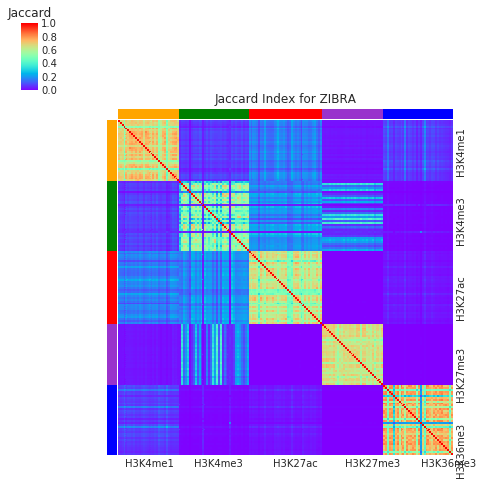

In [313]:
path, tool, title = root_path / "clean_ji_zinbra.csv", "zinbra", "ZIBRA"
if clear_cache:
    ! rm $path
build_fig8(OrderedDict([('H3K4me1', tool),
                        ('H3K4me3', tool),
                        ('H3K27ac', tool),
                        ('H3K27me3', tool),
                        ('H3K36me3', tool)]), 
           path, True, title, df_failed_tracks)

### Zinbra No Input

In [ ]:
path, tool, title = root_path / "clean_ji_zinbra_noinput.csv", "zinbra_noinput", "ZIBRA w/o Input"
if clear_cache:
    ! rm $path
build_fig8(OrderedDict([('H3K4me1', tool),
                        ('H3K4me3', tool),
                        ('H3K27ac', tool),
                        ('H3K27me3', tool),
                        ('H3K36me3', tool)]), 
           path, True, title, df_failed_tracks)

Tools:
  H3K4me1:zinbra_noinput
  H3K4me3:zinbra_noinput
  H3K27ac:zinbra_noinput
  H3K27me3:zinbra_noinput
  H3K36me3:zinbra_noinput

Tracks:
  H3K4me1 [32], OD_OD4_H3K4me1_1.0E-6_10_peaks.bed..YD_YD20_H3K4me1_1.0E-12_10_peaks.bed
  H3K4me3 [36], OD_OD1_H3K4me3_1.0E-4_10_peaks.bed..YD_YD21_H3K4me3_1.0E-6_10_peaks.bed
  H3K27ac [38], OD_OD1_H3K27ac_1.0E-6_5_peaks.bed..YD_YD21_H3K27ac_1.0E-12_2_peaks.bed
  H3K27me3 [32], OD_OD1_H3K27me3_1.0E-10_80_peaks.bed..YD_YD21_H3K27me3_1.0E-10_80_peaks.bed
  H3K36me3 [36], OD_OD1_H3K36me3_1.0E-10_40_peaks.bed..YD_YD21_H3K36me3_1.0E-8_40_peaks.bed

All donors paths: (first 5) or 174
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_noinput/clean/OD_OD4_H3K4me1_1.0E-6_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_noinput/clean/OD_OD5_H3K4me1_1.0E-6_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_noinput/clean/OD_OD6_H3K4me1_1.0E-8_10_peaks.bed


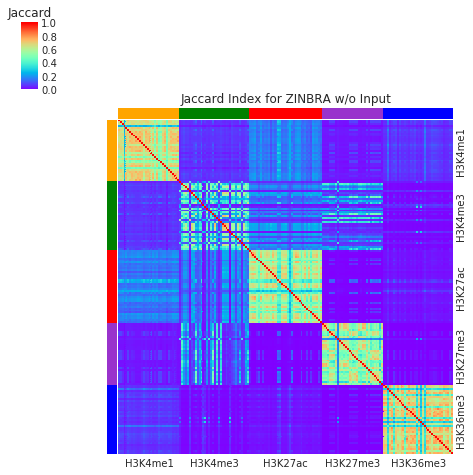

In [45]:
# path = root_path / "clean_ji_zinbra_noinput.csv"
# # ! rm $path
# build_fig8(OrderedDict([('H3K4me1', "zinbra_noinput"),
#                         ('H3K4me3', "zinbra_noinput"),
#                         ('H3K27ac', "zinbra_noinput"),
#                         ('H3K27me3', "zinbra_noinput"),
#                         ('H3K36me3', "zinbra_noinput")]), 
#            path, True, "ZINBRA w/o Input")

### Zinra Split

Tools:
  H3K4me1:zinbra_split
  H3K4me3:zinbra_split
  H3K27ac:zinbra_split
  H3K27me3:zinbra_split
  H3K36me3:zinbra_split

All Tracks:
  H3K4me1 [32], OD_OD4_H3K4me1_1.0E-6_10_peaks.bed..YD_YD20_H3K4me1_1.0E-10_5_peaks.bed
  H3K4me3 [40], OD_OD1_H3K4me3_0.01_10_peaks.bed..YD_YD21_H3K4me3_1.0E-4_10_peaks.bed
  H3K27ac [40], OD_OD1_H3K27ac_1.0E-4_2_peaks.bed..YD_YD21_H3K27ac_1.0E-10_5_peaks.bed
  H3K27me3 [40], OD_OD1_H3K27me3_1.0E-8_80_peaks.bed..YD_YD21_H3K27me3_1.0E-10_80_peaks.bed
  H3K36me3 [39], OD_OD1_H3K36me3_1.0E-8_40_peaks.bed..YD_YD21_H3K36me3_1.0E-6_40_peaks.bed

All donors paths: (first 5) or 191
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_split/OD_OD4_H3K4me1_1.0E-6_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_split/OD_OD5_H3K4me1_1.0E-4_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_split/OD_OD6_H3K4me1_1.0E-6_5_peaks.bed
    /mnt/stripe/bio/experiments/conf

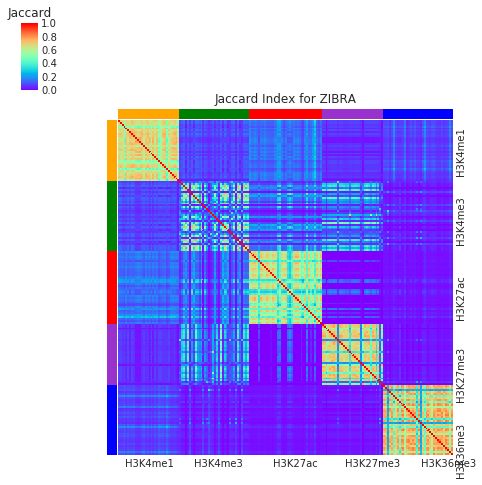

In [312]:
path, tool, title = root_path / "clean_ji_zinbra_split.csv", "zinbra_split", "ZIBRA"
if clear_cache:
    ! rm $path
build_fig8(OrderedDict([('H3K4me1', tool),
                        ('H3K4me3', tool),
                        ('H3K27ac', tool),
                        ('H3K27me3', tool),
                        ('H3K36me3', tool)]), 
           path, True, title, df_failed_tracks)

### Golden

Tools:
  H3K4me1:macs_broad
  H3K4me3:macs_broad
  H3K27ac:macs_broad
  H3K27me3:sicer
  H3K36me3:sicer

All Tracks:
  H3K4me1 [32], OD_OD4_H3K4me1_broad0.01_peaks.broadPeak..YD_YD20_H3K4me1_broad1.0E-6_peaks.broadPeak
  H3K4me3 [40], OD_OD1_H3K4me3_broad0.01_peaks.broadPeak..YD_YD21_H3K4me3_broad0.01_peaks.broadPeak
  H3K27ac [40], OD_OD1_H3K27ac_broad1.0E-4_peaks.broadPeak..YD_YD21_H3K27ac_broad1.0E-6_peaks.broadPeak
  H3K27me3 [40], OD_OD1_H3K27me3-W200-G200-FDR1.0E-8-island.bed..YD_YD21_H3K27me3-W200-G600-FDR1.0E-8-island.bed
  H3K36me3 [39], OD_OD1_H3K36me3-W200-G600-FDR1.0E-8-island.bed..YD_YD21_H3K36me3-W200-G1200-FDR1.0E-8-island.bed

All donors paths: (first 5) or 191
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/macs_broad/OD_OD4_H3K4me1_broad0.01_peaks.broadPeak
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/macs_broad/OD_OD5_H3K4me1_broad0.01_peaks.broadPeak
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/macs_b

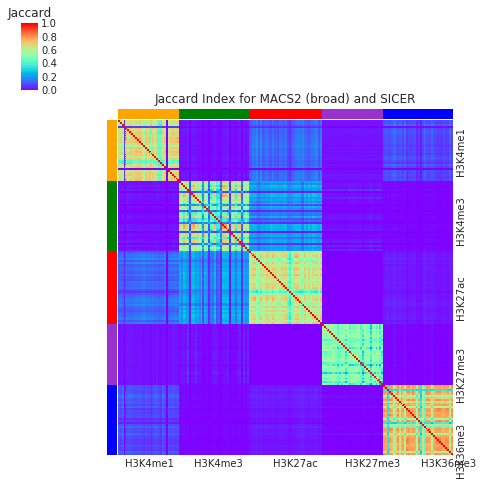

In [314]:
path = root_path / "clean_ji_golden.csv"
if clear_cache:
    ! rm $path
build_fig8(OrderedDict([('H3K4me1', "macs_broad"),
                        ('H3K4me3', "macs_broad"),
                        ('H3K27ac', "macs_broad"),
                        ('H3K27me3', "sicer"),
                        ('H3K36me3', "sicer")]), 
           path, True, "MACS2 (broad) and SICER", df_failed_tracks)

## Figure 8b (inclusion)

### Zinbra

Tools:
  H3K4me1:zinbra
  H3K4me3:zinbra
  H3K27ac:zinbra
  H3K27me3:zinbra
  H3K36me3:zinbra

All Tracks:
  H3K4me1 [32], OD_OD4_H3K4me1_1.0E-6_10_peaks.bed..YD_YD20_H3K4me1_1.0E-8_5_peaks.bed
  H3K4me3 [40], OD_OD1_H3K4me3_0.01_5_peaks.bed..YD_YD21_H3K4me3_1.0E-4_5_peaks.bed
  H3K27ac [40], OD_OD1_H3K27ac_1.0E-4_2_peaks.bed..YD_YD21_H3K27ac_1.0E-10_5_peaks.bed
  H3K27me3 [40], OD_OD1_H3K27me3_1.0E-8_80_peaks.bed..YD_YD21_H3K27me3_1.0E-10_80_peaks.bed
  H3K36me3 [39], OD_OD1_H3K36me3_1.0E-8_60_peaks.bed..YD_YD21_H3K36me3_1.0E-8_60_peaks.bed

All donors paths: (first 5) or 191
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD4_H3K4me1_1.0E-6_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD5_H3K4me1_1.0E-4_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD6_H3K4me1_1.0E-6_5_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD7_H3K4m

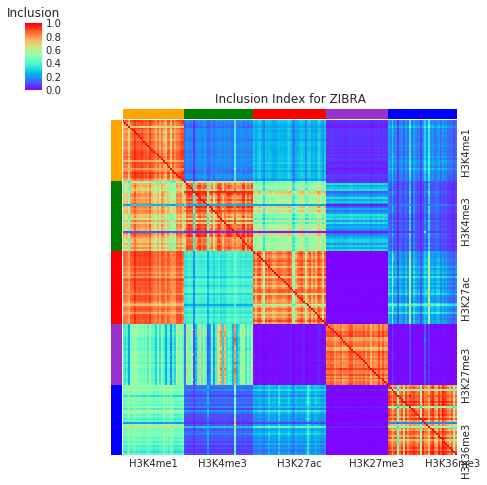

Tools:
  H3K4me1:zinbra
  H3K4me3:zinbra
  H3K27ac:zinbra
  H3K27me3:zinbra
  H3K36me3:zinbra

All Tracks:
  H3K4me1 [32], OD_OD4_H3K4me1_1.0E-6_10_peaks.bed..YD_YD20_H3K4me1_1.0E-8_5_peaks.bed
  H3K4me3 [40], OD_OD1_H3K4me3_0.01_5_peaks.bed..YD_YD21_H3K4me3_1.0E-4_5_peaks.bed
  H3K27ac [40], OD_OD1_H3K27ac_1.0E-4_2_peaks.bed..YD_YD21_H3K27ac_1.0E-10_5_peaks.bed
  H3K27me3 [40], OD_OD1_H3K27me3_1.0E-8_80_peaks.bed..YD_YD21_H3K27me3_1.0E-10_80_peaks.bed
  H3K36me3 [39], OD_OD1_H3K36me3_1.0E-8_60_peaks.bed..YD_YD21_H3K36me3_1.0E-8_60_peaks.bed

All donors paths: (first 5) or 191
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD4_H3K4me1_1.0E-6_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD5_H3K4me1_1.0E-4_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD6_H3K4me1_1.0E-6_5_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra/OD_OD7_H3K4m

In [316]:
path, tool, title = root_path / "clean_im_zinbra.csv", "zinbra", "ZIBRA"
if clear_cache:
    ! rm $path
build_fig8(OrderedDict([('H3K4me1', tool),
                        ('H3K4me3', tool),
                        ('H3K27ac', tool),
                        ('H3K27me3', tool),
                        ('H3K36me3', tool)]), 
           path, False, title, df_failed_tracks)

# save to PDF:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(str(root_path / "figure8.pdf")) as pdf:
    build_fig8(OrderedDict([('H3K4me1', tool),
                            ('H3K4me3', tool),
                            ('H3K27ac', tool),
                            ('H3K27me3', tool),
                            ('H3K36me3', tool)]), 
               path, False, title, df_failed_tracks,
           plot_path=pdf)

### Zinbra No Input

In [300]:
path, tool, title = root_path / "clean_im_zinbra_noinput.csv", "zinbra_noinput", "ZIBRA w/o Input"
if clear_cache:
    ! rm $path
build_fig8(OrderedDict([('H3K4me1', tool),
                        ('H3K4me3', tool),
                        ('H3K27ac', tool),
                        ('H3K27me3', tool),
                        ('H3K36me3', tool)]), 
           path, False, title, df_failed_tracks,
           plot_path="")

Tools:
  H3K4me1:zinbra_noinput
  H3K4me3:zinbra_noinput
  H3K27ac:zinbra_noinput
  H3K27me3:zinbra_noinput
  H3K36me3:zinbra_noinput

All Tracks:


AssertionError: No tracks for H3K4me1

Tools:
  H3K4me1:zinbra_noinput
  H3K4me3:zinbra_noinput
  H3K27ac:zinbra_noinput
  H3K27me3:zinbra_noinput
  H3K36me3:zinbra_noinput

Tracks:
  H3K4me1 [32], OD_OD4_H3K4me1_1.0E-6_10_peaks.bed..YD_YD20_H3K4me1_1.0E-12_10_peaks.bed
  H3K4me3 [36], OD_OD1_H3K4me3_1.0E-4_10_peaks.bed..YD_YD21_H3K4me3_1.0E-6_10_peaks.bed
  H3K27ac [38], OD_OD1_H3K27ac_1.0E-6_5_peaks.bed..YD_YD21_H3K27ac_1.0E-12_2_peaks.bed
  H3K27me3 [32], OD_OD1_H3K27me3_1.0E-10_80_peaks.bed..YD_YD21_H3K27me3_1.0E-10_80_peaks.bed
  H3K36me3 [36], OD_OD1_H3K36me3_1.0E-10_40_peaks.bed..YD_YD21_H3K36me3_1.0E-8_40_peaks.bed

All donors paths: (first 5) or 174
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_noinput/clean/OD_OD4_H3K4me1_1.0E-6_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_noinput/clean/OD_OD5_H3K4me1_1.0E-6_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_noinput/clean/OD_OD6_H3K4me1_1.0E-8_10_peaks.bed


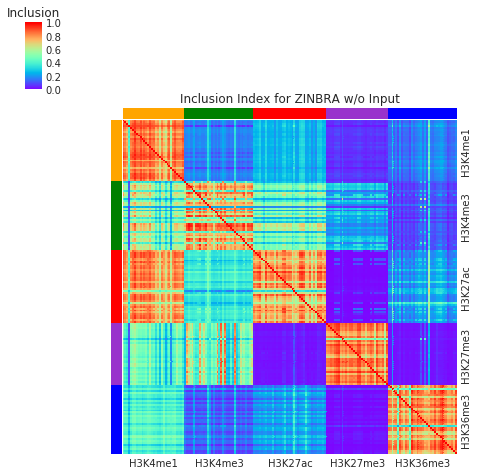

In [47]:
# path, tool, title = root_path / "clean_im_zinbra_noinput.csv", "zinbra_noinput", "ZIBRA w/o Input"
# if clear_cache:
#     ! rm $path
# build_fig8(OrderedDict([('H3K4me1', tool),
#                         ('H3K4me3', tool),
#                         ('H3K27ac', tool),
#                         ('H3K27me3', tool),
#                         ('H3K36me3', tool)]), 
#            path, False, title, df_failed_tracks,
#            plot_path="")

### Zinbra Split

Tools:
  H3K4me1:zinbra_split
  H3K4me3:zinbra_split
  H3K27ac:zinbra_split
  H3K27me3:zinbra_split
  H3K36me3:zinbra_split

All Tracks:
  H3K4me1 [32], OD_OD4_H3K4me1_1.0E-6_10_peaks.bed..YD_YD20_H3K4me1_1.0E-10_5_peaks.bed
  H3K4me3 [40], OD_OD1_H3K4me3_0.01_10_peaks.bed..YD_YD21_H3K4me3_1.0E-4_10_peaks.bed
  H3K27ac [40], OD_OD1_H3K27ac_1.0E-4_2_peaks.bed..YD_YD21_H3K27ac_1.0E-10_5_peaks.bed
  H3K27me3 [40], OD_OD1_H3K27me3_1.0E-8_80_peaks.bed..YD_YD21_H3K27me3_1.0E-10_80_peaks.bed
  H3K36me3 [39], OD_OD1_H3K36me3_1.0E-8_40_peaks.bed..YD_YD21_H3K36me3_1.0E-6_40_peaks.bed

All donors paths: (first 5) or 191
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_split/OD_OD4_H3K4me1_1.0E-6_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_split/OD_OD5_H3K4me1_1.0E-4_10_peaks.bed
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/zinbra_split/OD_OD6_H3K4me1_1.0E-6_5_peaks.bed
    /mnt/stripe/bio/experiments/conf

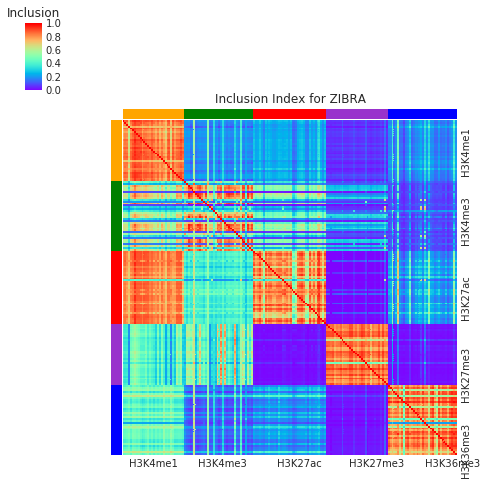

In [315]:
path, tool, title = root_path / "clean_im_zinbra_split.csv", "zinbra_split", "ZIBRA"
if clear_cache:
    ! rm $path
build_fig8(OrderedDict([('H3K4me1', tool),
                        ('H3K4me3', tool),
                        ('H3K27ac', tool),
                        ('H3K27me3', tool),
                        ('H3K36me3', tool)]), 
           path, False, title, df_failed_tracks)

### Golden

Tools:
  H3K4me1:macs_broad
  H3K4me3:macs_broad
  H3K27ac:macs_broad
  H3K27me3:sicer
  H3K36me3:sicer

All Tracks:
  H3K4me1 [32], OD_OD4_H3K4me1_broad0.01_peaks.broadPeak..YD_YD20_H3K4me1_broad1.0E-6_peaks.broadPeak
  H3K4me3 [40], OD_OD1_H3K4me3_broad0.01_peaks.broadPeak..YD_YD21_H3K4me3_broad0.01_peaks.broadPeak
  H3K27ac [40], OD_OD1_H3K27ac_broad1.0E-4_peaks.broadPeak..YD_YD21_H3K27ac_broad1.0E-6_peaks.broadPeak
  H3K27me3 [40], OD_OD1_H3K27me3-W200-G200-FDR1.0E-8-island.bed..YD_YD21_H3K27me3-W200-G600-FDR1.0E-8-island.bed
  H3K36me3 [39], OD_OD1_H3K36me3-W200-G600-FDR1.0E-8-island.bed..YD_YD21_H3K36me3-W200-G1200-FDR1.0E-8-island.bed

All donors paths: (first 5) or 191
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/macs_broad/OD_OD4_H3K4me1_broad0.01_peaks.broadPeak
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/macs_broad/OD_OD5_H3K4me1_broad0.01_peaks.broadPeak
    /mnt/stripe/bio/experiments/configs/benchmark/benchmark/H3K4me1/macs_b

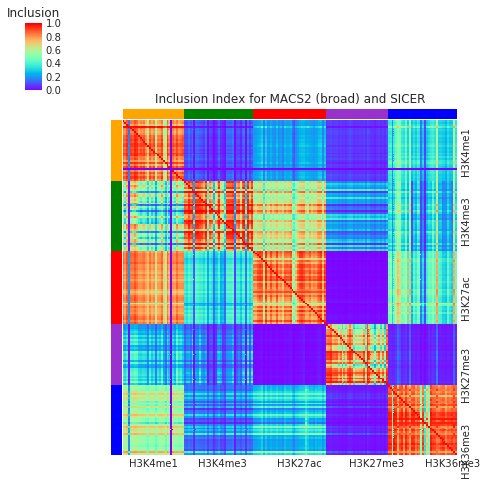

In [305]:
path = root_path / "clean_im_golden.csv"
if clear_cache:
    ! rm $path
build_fig8(OrderedDict([('H3K4me1', "macs_broad"),
                        ('H3K4me3', "macs_broad"),
                        ('H3K27ac', "macs_broad"),
                        ('H3K27me3', "sicer"),
                        ('H3K36me3', "sicer")]), 
           path, False, "MACS2 (broad) and SICER", df_failed_tracks)

# Figure 1

In [54]:
# run LibDepthSummaryReport --all --config ./experiments/src/main/resources/datasets/Y20O20.yaml -o /mnt/stripe/bio/experiments/aging/Y20O20.all.libdepth.all.csv

#lib_depth_path = "/mnt/stripe/bio/experiments/aging/Y20O20.libdepth.csv"
# lib_depth_title = "Sequencing Depth (average and std) w/o failed tracks"

lib_depth_path = "/mnt/stripe/bio/experiments/aging/Y20O20.libdepth.all.csv"
lib_depth_title = "Sequencing Depth (average and std)"

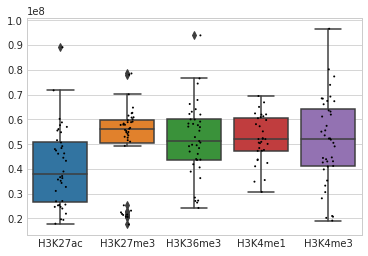

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3
donor,,,,,
OD1,36673710,58893954,66233300.0,NaN,52305782
OD10,47446636,55762890,62210838.0,58085876.0,42610619
OD11,24676060,60083388,36292147.0,61271323.0,44658687
OD12,24002157,54792741,48417773.0,50612713.0,49108323
OD13,34334025,51601696,58194868.0,66888267.0,43094680


In [55]:
df = pd.read_csv(lib_depth_path, sep="\t", comment="#", index_col=0)
df = df.drop("Input", axis=1)

import seaborn as sns
sns.set_style("whitegrid")
sns.boxplot(data=df)
sns.stripplot(data=df, size=2, jitter=True, color="black")
plt.show()
df.head()

In [148]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lib_depth(lib_depth_path,  title,
                   donor_labels = True,
                   plot_path=None):
    df = pd.read_csv(lib_depth_path, sep="\t", comment="#", index_col=None)
    df = df.drop("Input", axis=1)
    df = pd.melt(df, var_name='hist', value_name='depth', id_vars=["donor"])
    df["age"] = "Young"
    df.loc[df.donor.str.startswith("OD"), "age"] = "Old"
    df["depth"] = df["depth"]/1000000
    hist_mods = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K36me3"]

    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(8,6))
    sns.set_style("whitegrid")
    #hue=age,  order=["H3K4me1", .. "Lunch"], ci=68 confidence interval, estimator=np.median, color="salmon", saturation=.5
    # errcolor="red", errwidth=0.3
    ax = sns.barplot(data=df, 
                     x="hist", y="depth",
                     order=hist_mods,
                     ci="sd", capsize=.2, errwidth=2, # error bars
                     # hue="age",
                     # facecolor=(1, 1, 1, 0), # do not fill with color
                     color="lightgray",
                     edgecolor="black")

    age_palette={"Young":"red", "Old": "blue"}
    # swarmplot: no intersection, stripplot: intersected
    ax = sns.swarmplot(data=df, 
                  x="hist", y="depth",
                  size=5, 
                  order=hist_mods,
                  linewidth=1, # edge line width
                  hue = "age",
                  palette=age_palette,
                  #jitter=True
                 )

    if donor_labels:
        for i, h in enumerate(hist_mods):
            hdf = df[df["hist"] == h].dropna()
        #     l_min, l_max = np.percentile(hdf["depth"], q=[25, 75])
            l_min = np.mean(hdf["depth"]) - np.std(hdf["depth"])
            l_max = np.mean(hdf["depth"]) + np.std(hdf["depth"])
        #     print(h, l_min, l_max)
            for donor, depth, age in zip(hdf["donor"].tolist(), hdf["depth"].tolist(), hdf["age"]):
                if depth < l_min or depth > l_max:
                    ax.text(i, depth, donor, color=age_palette[age], fontsize=8)

    plt.title(title)
    # plt.ticklabel_format(style='plain', axis='y',useOffset=True)
    plt.ylabel("Millions Reads")
    plt.xlabel("")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    bm.save_plot(plot_path)
    # plot.show

/home/user/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


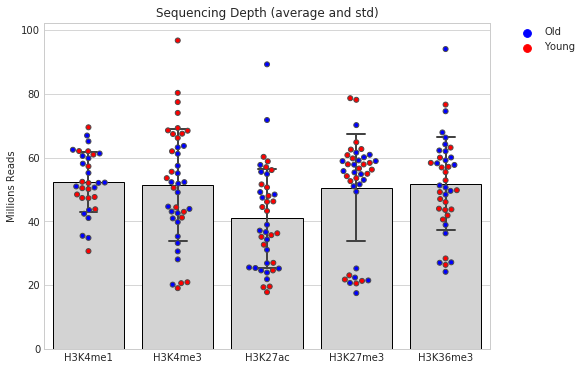

In [73]:
plot_lib_depth(lib_depth_path, lib_depth_title, donor_labels=False)

from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(str(root_path / "figure1.pdf")) as pdf:
    plot_lib_depth(lib_depth_path, lib_depth_title, donor_labels=False, plot_path=pdf)

# Lib Depth By Chr

In [217]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lib_depth_by_chr(df, title, 
                          donor_labels = True,
                          cols = None,
                          plot_path=None):

    if cols is None:
        cols = df.columns.tolist()
        cols.remove("donor")

    df = pd.melt(df, var_name='chr', value_name='depth', id_vars=["donor"])
    df["age"] = "Young"
    df.loc[df.donor.str.startswith("OD"), "age"] = "Old"
    df["depth"] = df["depth"]/1000000

    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(14,6))
    sns.set_style("whitegrid")
    #hue=age,  order=["H3K4me1", .. "Lunch"], ci=68 confidence interval, estimator=np.median, color="salmon", saturation=.5
    # errcolor="red", errwidth=0.3
    ax = sns.barplot(data=df, 
                     x="chr", y="depth",
                     order=cols,
                     ci="sd", capsize=.2, errwidth=2, # error bars
                     # hue="age",
                     # facecolor=(1, 1, 1, 0), # do not fill with color
                     color="lightgray",
                     edgecolor="black")

    age_palette={"Young":"red", "Old": "blue"}
    # swarmplot: no intersection, stripplot: intersected
    ax = sns.swarmplot(data=df, 
                  x="chr", y="depth",
                  size=3, #5
                  order=cols,
                  #linewidth=1, # edge line width
                  hue = "age",
                  palette=age_palette,
                  #jitter=True
                 )

    if donor_labels:
        for i, chr in enumerate(cols):
            hdf = df[df["chr"] == chr].dropna()
        #     l_min, l_max = np.percentile(hdf["depth"], q=[25, 75])
            l_min = np.mean(hdf["depth"]) - np.std(hdf["depth"])
            l_max = np.mean(hdf["depth"]) + np.std(hdf["depth"])
        #     print(h, l_min, l_max)
            for donor, depth, age in zip(hdf["donor"].tolist(), hdf["depth"].tolist(), hdf["age"]):
                if depth < l_min or depth > l_max:
                    ax.text(i, depth, donor, color=age_palette[age], fontsize=8)

    plt.title(title)
    # plt.ticklabel_format(style='plain', axis='y',useOffset=True)
    plt.ylabel("Millions Reads")
    plt.xlabel("")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    bm.save_plot(plot_path)
    # plot.show

In [202]:
# run LibDepthSummaryReport --all --config ./experiments/src/main/resources/datasets/Y20O20.yaml --split -o /mnt/stripe/bio/experiments/aging/Y20O20.all.libdepth.all.bychrs.csv
lib_depth_path = "/mnt/stripe/bio/experiments/aging/Y20O20.all.libdepth.all.bychrs.csv"

In [203]:
df = pd.read_csv(lib_depth_path, sep="\t", comment="#", index_col=0)
df.head()

,H3K27ac_chr1,H3K27me3_chr1,H3K36me3_chr1,H3K4me1_chr1,H3K4me3_chr1,Input_chr1,H3K27ac_chr2,H3K27me3_chr2,H3K36me3_chr2,H3K4me1_chr2,...,H3K36me3_chr22,H3K4me1_chr22,H3K4me3_chr22,Input_chr22,H3K27ac_chr21,H3K27me3_chr21,H3K36me3_chr21,H3K4me1_chr21,H3K4me3_chr21,Input_chr21
donor,,,,,,,,,,,,,,,,,,,,,
OD1,2767860,4438059,5605645.0,NaN,3769926,NaN,2570588,4149384,4768111.0,NaN,...,1165895.0,NaN,579126,NaN,407112,567528,679363.0,NaN,573229,NaN
OD10,3865863,3925011,5340748.0,4967805.0,3106001,NaN,3391128,3950071,4418023.0,4052060.0,...,1188554.0,1145843.0,559107,NaN,542823,607867,657712.0,716069.0,466566,NaN
OD11,1959868,4288217,3112330.0,4849641.0,3198710,NaN,1760967,4318772,2547375.0,4267619.0,...,718053.0,994104.0,543918,NaN,274967,620449,384473.0,723631.0,483758,NaN
OD12,1903024,3888459,4122656.0,4236319.0,3564281,NaN,1662935,3863433,3454478.0,3564085.0,...,871053.0,907986.0,617087,NaN,262747,578950,502608.0,613821.0,531286,NaN
OD13,2871828,3890339,4924427.0,5859619.0,3200471,NaN,2463117,3687950,4121079.0,4888911.0,...,1085829.0,1174895.0,562599,NaN,390588,505869,614577.0,816766.0,465485,NaN


In [204]:
from itertools import groupby
from collections import defaultdict, OrderedDict

In [205]:
col_details = OrderedDict((t, t.split("_")) for t in df.columns)
by_hist = defaultdict(list)
for k, (hist, chr) in col_details.items():
    by_hist[hist].append((k, chr))

del by_hist["Input"]

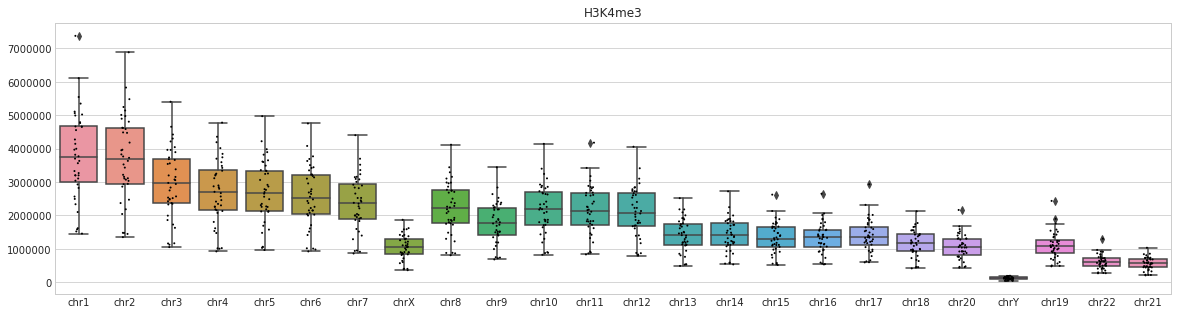

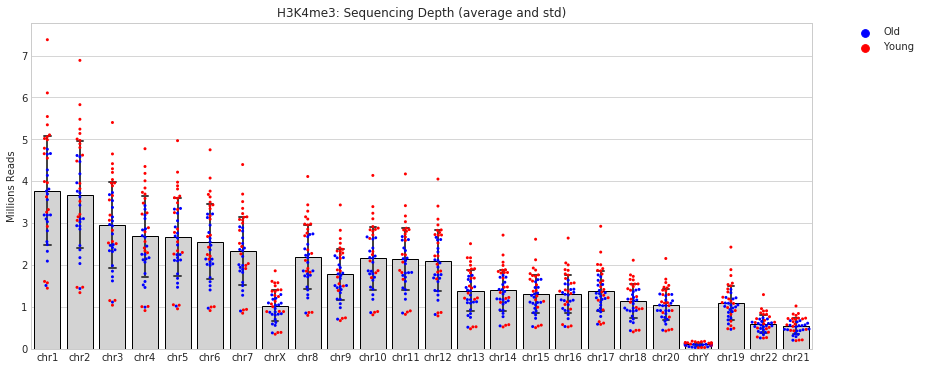

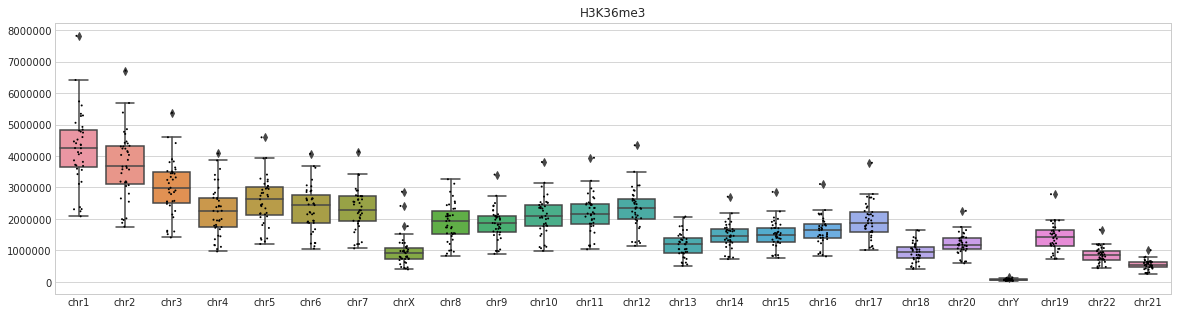

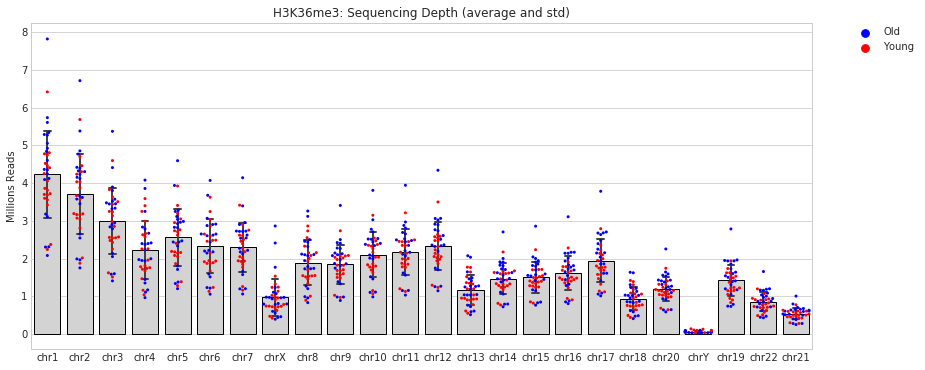

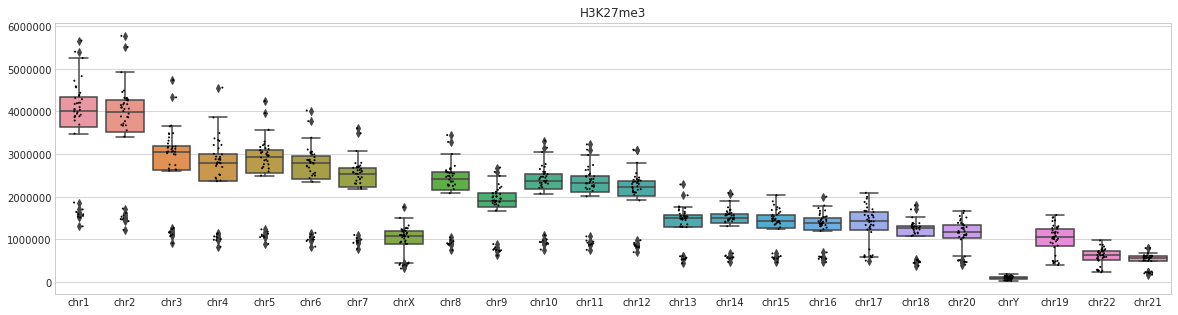

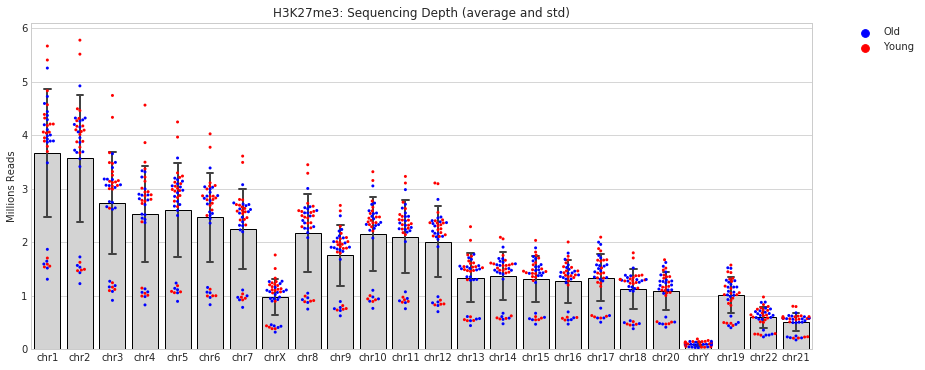

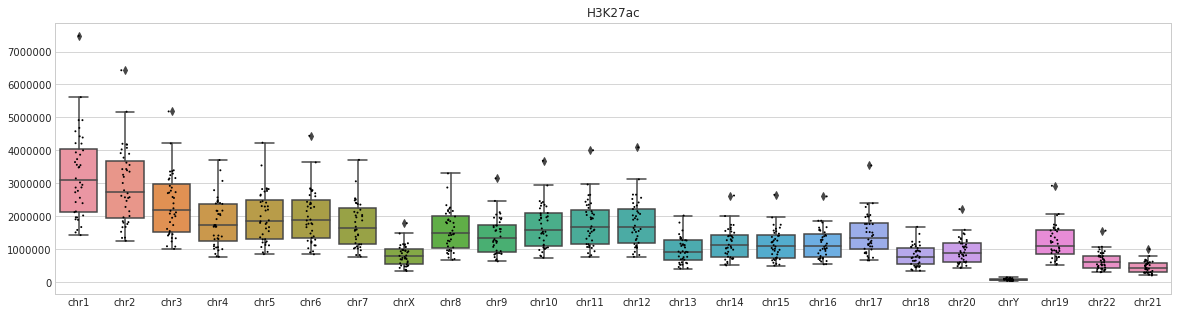

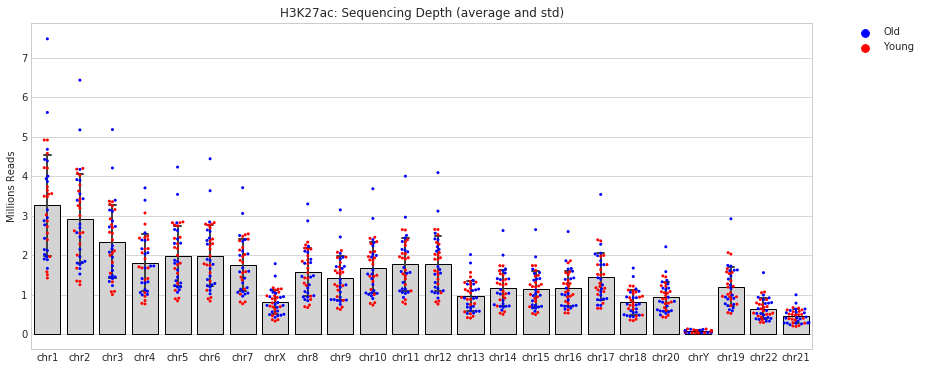

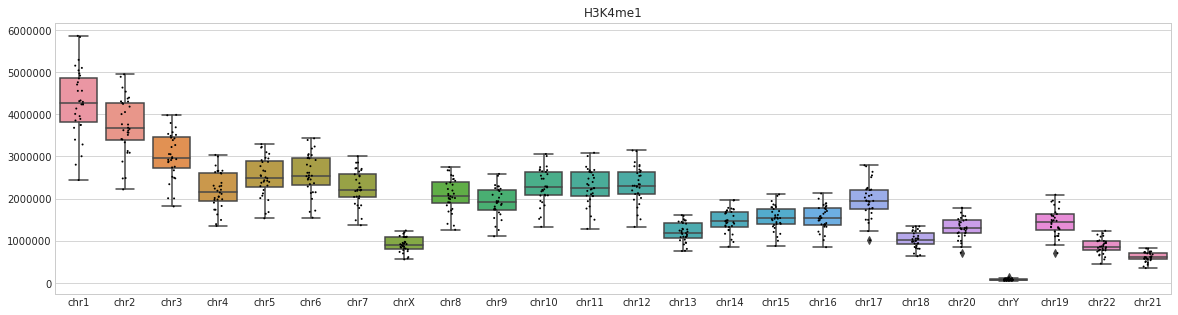

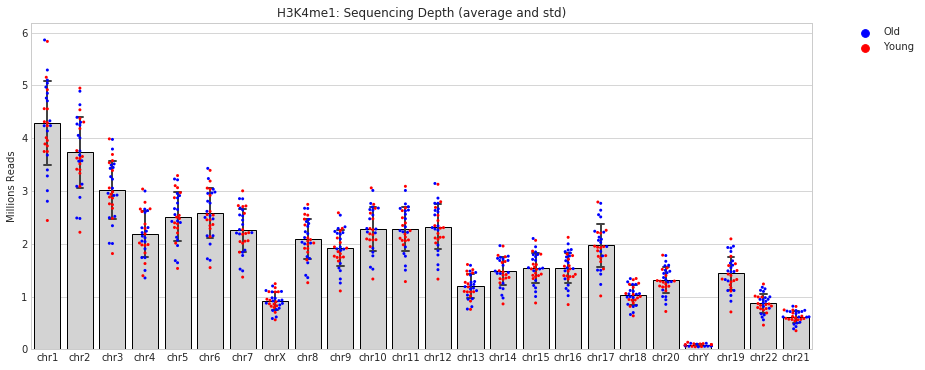

In [206]:
import seaborn as sns
sns.set_style("whitegrid")

for hist, values in by_hist.items():
    cols, chrs = zip(*values)
    sdf = df.loc[:, cols]
    sdf.columns = chrs

    # version a)
    plt.figure(figsize=(20, 5))
    sns.boxplot(data=sdf)
    sns.stripplot(data=sdf, size=2, jitter=True, color="black")
    plt.title(hist)
    plt.show()
    
    # version b)
    sdf['donor'] = sdf.index
    plot_lib_depth_by_chr(sdf, "{}: Sequencing Depth (average and std)".format(hist), donor_labels=False)    

## Averaged by donor

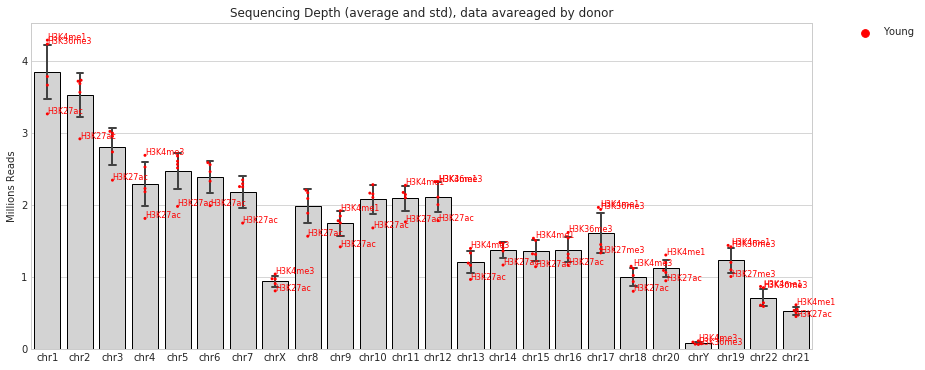

In [218]:
# For peter:
# df = pd.read_csv(lib_depth_path, sep="\t", comment="#", index_col=0)
avg_df = pd.DataFrame(df.mean(), columns=["val"])
avg_df.loc[:, "hist"], avg_df.loc[:, "chr"] = list(zip(*avg_df.index.str.split("_")))
avg_df = avg_df.pivot(index='chr', columns='hist', values='val')
avg_df.drop("Input", axis=1)
#print(avg_df.head())

# plt.figure(figsize=(20, 5))
# sns.boxplot(data=avg_df.T)
# sns.stripplot(data=avg_df.T, size=2, jitter=True, color="black")
# plt.title(hist)
# plt.show()

tmp = avg_df.T
tmp["donor"] = tmp.index
plot_lib_depth_by_chr(tmp, "Sequencing Depth (average and std), data avareaged by donor".format(hist), donor_labels=True,
                      cols=list(OrderedDict([(s.split("_")[1], 1) for s in df.columns]).keys()))

# FRIP

In [115]:
hist_mods = OrderedDict([('H3K4me1', "zinbra"),
                         ('H3K4me3', "zinbra"),
                         ('H3K27ac', "zinbra"),
                         ('H3K27me3', "zinbra"),
                         ('H3K36me3', "zinbra")])
                        
print("Tools:")
print(*["  {}:{}".format(k, v) for k,v in hist_mods.items()], sep="\n")

# -----------------------------------
# Collect tracks:
for f in hfolders:
    match = re.match(".*/(H[^/]*)/([^/]*).*", f, flags=re.IGNORECASE)
    assert match
    hist = match.group(1)
    tool = match.group(2)

    if hist_mods[hist] != tool:
        continue

    tracks = loi._collect_peaks_in_folder(Path(f))
    rips = [p.with_suffix(".bed_rip.csv") for p in tracks]
    donors_and_tools = [bm.label_converter_donor_and_tool(p.name.replace("_rip.csv", "")) for p in rips]
    donors = [dt.split("_")[0] for dt in donors_and_tools]
    metrics = ["/mnt/stripe/bio/experiments/configs/Y20O20/unique/{}/{}_{}_{}_metrics.txt".format(h, d[0:2], d, h) for d in donors]
    
    for (r_path, m_path, d) in zip(rips, metrics, donors):
        m_df = pd.read_csv(m_path,  sep="\t", comment="#")
        usable_reads = m_df["UNPAIRED_READS_EXAMINED"][0] - m_df["UNPAIRED_READ_DUPLICATES"][0]
        
        r_df = pd.read_csv(r_path)
        print("{} {}: {} vs {}".format(hist, d, r_df["reads"][0], usable_reads))

# print("\nTracks Rip:")
# for h in hist_mods:
#     tracks = hist_2_rip[h]
#     assert tracks, "No tracks for {}".format(h)
#     print("  {} [{}], {}..{}".format(
#         h, len(tracks), Path(tracks[0]).name, Path(tracks[-1]).name)
#     )

# all_donors_paths = list(chain(*(hist_2_rip[h] for h in hist_mods)))
# print("\nAll donors rip paths: (first 5) or {}".format(len(all_donors_paths)),
#       *all_donors_paths[0:5], sep="\n    ")

# all_donors_labels = list(chain(
#     *([h + "_" + bm.label_converter_donor_and_tool(p.name.replace("_rip.csv", "")) for p in hist_2_rip[h]] for h in hist_mods)
# ))
                        
# # all_donors_labels
# print("\nAll donors short labels: (first 5) or {}".format(len(all_donors_labels)),
#           *all_donors_labels[0:5], sep="\n   ")

# all_donors_metrics = []
# for h in hist_mods:
#     donors = [bm.label_converter_donor_and_tool(p.name.replace("_rip.csv", "")).split("_")[0] for p in hist_2_rip[h]]
#     all_donors_metrics.extend(["/mnt/stripe/bio/experiments/configs/Y20O20/unique/{}/{}_{}_{}_metrics.txt".format(h, d[0:2], d, h) for d in donors])
    
# all_donors_metrics[0:5]

Tools:
  H3K4me1:zinbra
  H3K4me3:zinbra
  H3K27ac:zinbra
  H3K27me3:zinbra
  H3K36me3:zinbra
H3K27ac OD1: 31047948 vs 48560314
H3K27ac OD2: 32039420 vs 38010857


FileNotFoundError: File b'/mnt/stripe/bio/experiments/configs/Y20O20/unique/H3K36me3/OD_OD3_H3K36me3_metrics.txt' does not exist